In [2]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from skimage.filters import threshold_otsu
plt.style.use("ggplot")
%matplotlib inline

from tqdm import tqdm_notebook, tnrange
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.filters import threshold_otsu
from skimage.morphology import label
from sklearn.model_selection import train_test_split

import tensorflow as tf

from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers.merge import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

In [3]:
# Set some parameters
im_width = 128
im_height = 128
border = 5

In [4]:
ids = next(os.walk("images"))[2] # list of names all images in the given path
print("No. of images = ", len(ids))

No. of images =  1377


In [5]:
X = np.zeros((len(ids), im_height, im_width, 1), dtype=np.float32)
y = np.zeros((len(ids), im_height, im_width, 1), dtype=np.float32)

#### Load the images and masks into arrays

In [6]:
# tqdm is used to display the progress bar
for n, id_ in tqdm_notebook(enumerate(ids), total=len(ids)):
    # Load images
    img = load_img("images/"+id_, grayscale = True)
    x_img = img_to_array(img)
    # not needed if the resize script is used
    # x_img = resize(x_img, (128, 128, 1), mode = 'constant', preserve_range = True)
    # Load masks
    mask = load_img("masks/"+id_, grayscale = True)
    mask = img_to_array(mask)
    # not needed if the resize script is used
    # mask = resize(mask, (128, 128, 1), mode = 'constant', preserve_range = True)

    # Save images
    X[n] = x_img/255.0
    y[n] = mask/255.0

<ipython-input-6-3b0a0ddce257>:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for n, id_ in tqdm_notebook(enumerate(ids), total=len(ids)):


  0%|          | 0/1377 [00:00<?, ?it/s]

c:\users\ncoma\documents\workspace_py\3d-prostate-segmentation\venv\lib\site-packages\keras_preprocessing\image\utils.py:107: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


In [7]:
# Split train and valid
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1, random_state=42)

#### Below code can be used to visualize the images and corresponding masks

<ipython-input-11-a74826363aca>:10: UserWarning: No contour levels were found within the data range.
  ax1.contour(y_train[ix].squeeze(), colors = 'k', linewidths = 5, levels = [0.5])


Text(0.5, 1.0, 'Lesion')

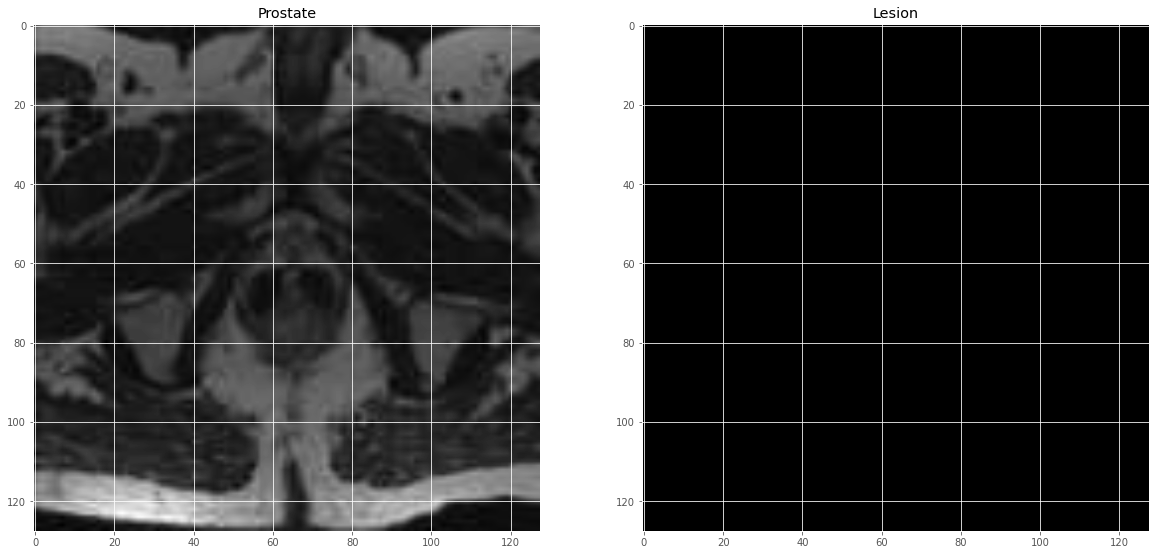

In [11]:
# Visualize any random image along with the mask
ix = random.randint(0, len(X_train))
has_mask = y_train[ix].max() > 0 # injury indicator

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 15))

ax1.imshow(X_train[ix, ..., 0], cmap = 'gray', interpolation = 'bilinear')
if has_mask: # if lesion exists
    # draw a boundary(contour) in the original image indicated the lesion
    ax1.contour(y_train[ix].squeeze(), colors = 'k', linewidths = 5, levels = [0.5])
ax1.set_title('Prostate')

ax2.imshow(y_train[ix].squeeze(), cmap = 'gray', interpolation = 'bilinear')
ax2.set_title('Lesion')

In [12]:
def conv2d_block(input_tensor, n_filters, kernel_size = 3, batchnorm = True):
    """Function to add 2 convolutional layers with the parameters passed to it"""
    # first layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # second layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(x)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    return x

In [13]:
def get_unet(input_img, n_filters = 16, dropout = 0.1, batchnorm = True):
    """Function to define the UNET Model"""
    # Contracting Path
    c1 = conv2d_block(input_img, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = Dropout(dropout)(p1)
    
    c2 = conv2d_block(p1, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(dropout)(p2)
    
    c3 = conv2d_block(p2, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = Dropout(dropout)(p3)
    
    c4 = conv2d_block(p3, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    p4 = MaxPooling2D((2, 2))(c4)
    p4 = Dropout(dropout)(p4)
    
    c5 = conv2d_block(p4, n_filters = n_filters * 16, kernel_size = 3, batchnorm = batchnorm)
    
    # Expansive Path
    u6 = Conv2DTranspose(n_filters * 8, (3, 3), strides = (2, 2), padding = 'same')(c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    
    u7 = Conv2DTranspose(n_filters * 4, (3, 3), strides = (2, 2), padding = 'same')(c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    
    u8 = Conv2DTranspose(n_filters * 2, (3, 3), strides = (2, 2), padding = 'same')(c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    
    u9 = Conv2DTranspose(n_filters * 1, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = concatenate([u9, c1])
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model

In [14]:
input_img = Input((im_height, im_width, 1), name='img')
model = get_unet(input_img, n_filters=16, dropout=0.05, batchnorm=True)
model.compile(optimizer=Adam(), loss="binary_crossentropy", metrics=["accuracy"])

In [15]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 16) 160         img[0][0]                        
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 128, 128, 16) 64          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 128, 128, 16) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [16]:
callbacks = [
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1),
    ModelCheckpoint('model-prostate.h5', verbose=1, save_best_only=True, save_weights_only=True)
]

In [17]:
results = model.fit(X_train, y_train, batch_size=32, epochs=50, callbacks=callbacks,\
                    validation_data=(X_valid, y_valid))

Epoch 1/50
39/39 [==============================] - 117s 3s/step - loss: 0.5742 - accuracy: 0.0000e+00 - val_loss: 117.5011 - val_accuracy: 0.0000e+00

Epoch 00001: val_loss improved from inf to 117.50111, saving model to model-prostate.h5
Epoch 2/50
39/39 [==============================] - 116s 3s/step - loss: 0.4080 - accuracy: 0.0000e+00 - val_loss: 0.5779 - val_accuracy: 0.0000e+00

Epoch 00002: val_loss improved from 117.50111 to 0.57786, saving model to model-prostate.h5
Epoch 3/50
39/39 [==============================] - 122s 3s/step - loss: 0.3929 - accuracy: 0.0000e+00 - val_loss: 0.5326 - val_accuracy: 0.0000e+00

Epoch 00003: val_loss improved from 0.57786 to 0.53262, saving model to model-prostate.h5
Epoch 4/50
39/39 [==============================] - 116s 3s/step - loss: 0.3851 - accuracy: 0.0000e+00 - val_loss: 0.4071 - val_accuracy: 0.0000e+00

Epoch 00004: val_loss improved from 0.53262 to 0.40714, saving model to model-prostate.h5
Epoch 5/50
39/39 [====================

39/39 [==============================] - 115s 3s/step - loss: 0.3657 - accuracy: 0.0000e+00 - val_loss: 0.3674 - val_accuracy: 0.0000e+00

Epoch 00037: val_loss improved from 0.36747 to 0.36741, saving model to model-prostate.h5
Epoch 38/50
39/39 [==============================] - 115s 3s/step - loss: 0.3659 - accuracy: 0.0000e+00 - val_loss: 0.3674 - val_accuracy: 0.0000e+00

Epoch 00038: val_loss did not improve from 0.36741
Epoch 39/50
39/39 [==============================] - 115s 3s/step - loss: 0.3658 - accuracy: 0.0000e+00 - val_loss: 0.3674 - val_accuracy: 0.0000e+00

Epoch 00039: val_loss improved from 0.36741 to 0.36736, saving model to model-prostate.h5
Epoch 40/50
39/39 [==============================] - 115s 3s/step - loss: 0.3658 - accuracy: 0.0000e+00 - val_loss: 0.3675 - val_accuracy: 0.0000e+00

Epoch 00040: val_loss did not improve from 0.36736
Epoch 41/50
39/39 [==============================] - 115s 3s/step - loss: 0.3659 - accuracy: 0.0000e+00 - val_loss: 0.3674 - v

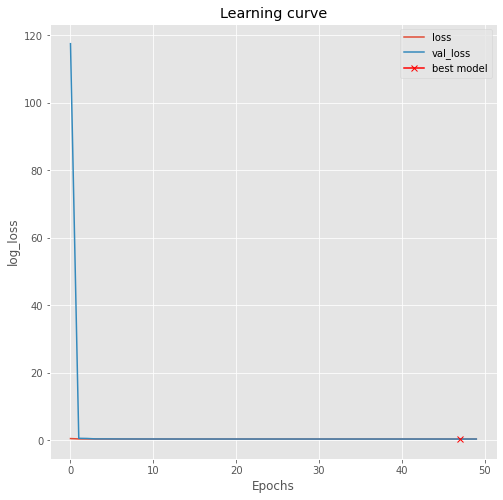

In [18]:
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(results.history["loss"], label="loss")
plt.plot(results.history["val_loss"], label="val_loss")
plt.plot( np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();

### Inference

In [19]:
# load the best model
model.load_weights('model-prostate.h5')

In [20]:
# Evaluate on validation set (this must be equals to the best log_loss)
model.evaluate(X_valid, y_valid, verbose=1)

5/5 [==============================] - 2s 338ms/step - loss: 0.3673 - accuracy: 0.0000e+00


[0.3673389256000519, 0.0]

In [21]:
# Predict on train, val and test
preds_train = model.predict(X_train, verbose=1)
preds_val = model.predict(X_valid, verbose=1)

5/5 [==============================] - 2s 343ms/step


In [22]:
# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)

In [23]:
def plot_sample(X, y, preds, binary_preds, ix=None):
    """Function to plot the results"""
    if ix is None:
        ix = random.randint(0, len(X))

    has_mask = y[ix].max() > 0

    fig, ax = plt.subplots(1, 4, figsize=(20, 10))
    ax[0].imshow(X[ix, ..., 0], cmap='seismic')
    if has_mask:
        ax[0].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[0].set_title('Prostate')

    ax[1].imshow(y[ix].squeeze())
    ax[1].set_title('Lesion')

    ax[2].imshow(preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[2].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[2].set_title('Lesion Predicted')
    
    ax[3].imshow(binary_preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[3].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[3].set_title('Lesion Predicted binary');

### Predictions on training set

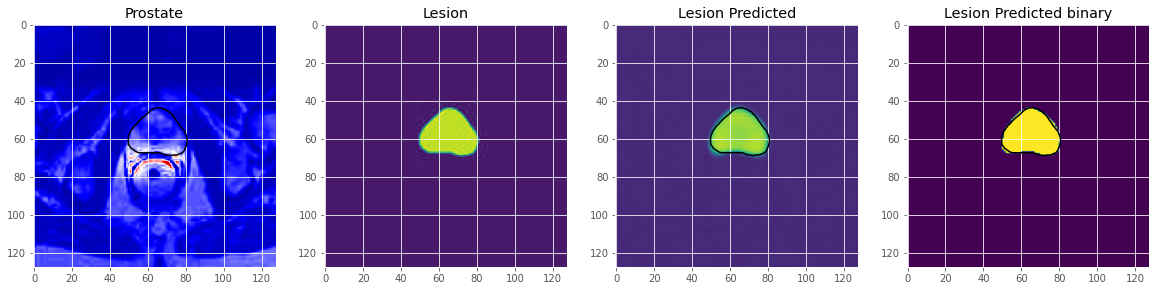

In [24]:
# Check if training data looks all right
plot_sample(X_train, y_train, preds_train, preds_train_t, ix=14)

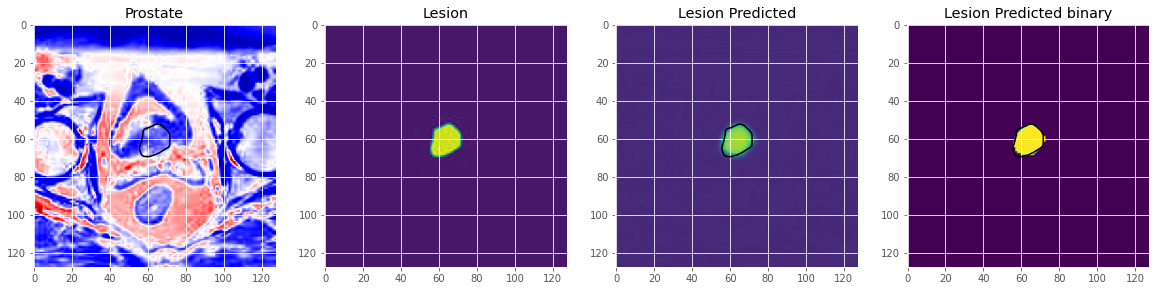

In [25]:
plot_sample(X_train, y_train, preds_train, preds_train_t)

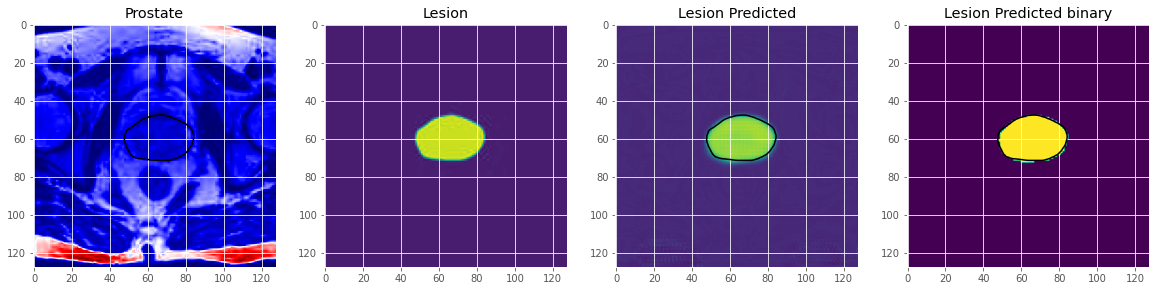

In [26]:
plot_sample(X_train, y_train, preds_train, preds_train_t)

<ipython-input-23-111460d6459c>:11: UserWarning: No contour levels were found within the data range.
  ax[0].contour(y[ix].squeeze(), colors='k', levels=[0.5])
<ipython-input-23-111460d6459c>:19: UserWarning: No contour levels were found within the data range.
  ax[2].contour(y[ix].squeeze(), colors='k', levels=[0.5])
<ipython-input-23-111460d6459c>:24: UserWarning: No contour levels were found within the data range.
  ax[3].contour(y[ix].squeeze(), colors='k', levels=[0.5])


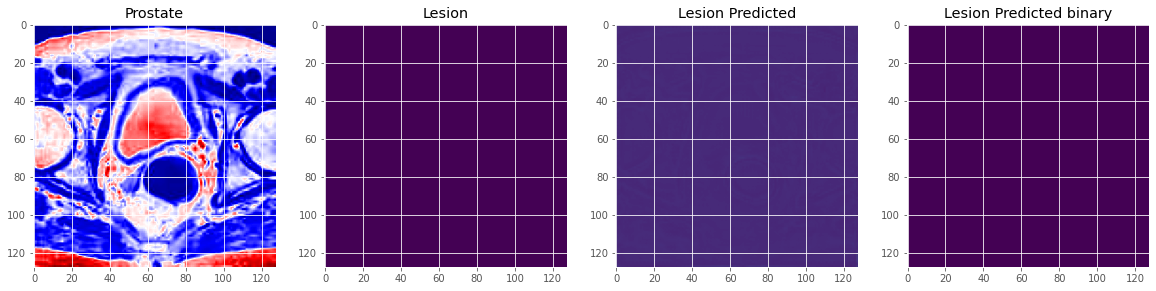

In [27]:
plot_sample(X_train, y_train, preds_train, preds_train_t)

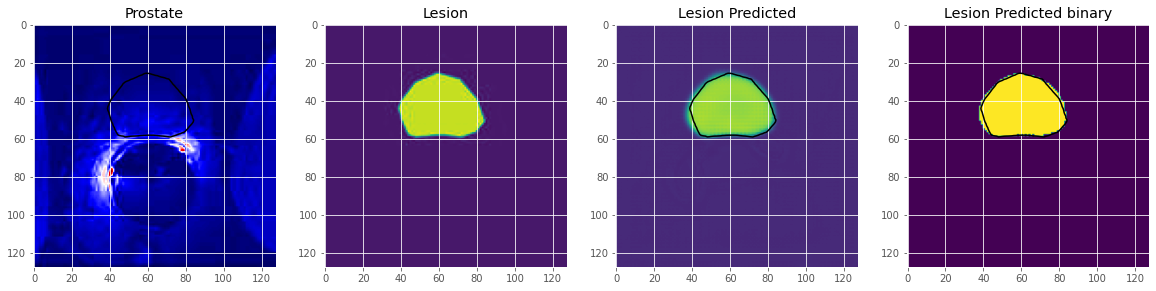

In [28]:
plot_sample(X_train, y_train, preds_train, preds_train_t)

In [ ]:
plot_sample(X_train, y_train, preds_train, preds_train_t)

In [ ]:
plot_sample(X_train, y_train, preds_train, preds_train_t)

In [ ]:
plot_sample(X_train, y_train, preds_train, preds_train_t)

In [ ]:
plot_sample(X_train, y_train, preds_train, preds_train_t)

In [ ]:
plot_sample(X_train, y_train, preds_train, preds_train_t)

In [ ]:
plot_sample(X_train, y_train, preds_train, preds_train_t)

In [ ]:
plot_sample(X_train, y_train, preds_train, preds_train_t)

### Predictions on test set

<ipython-input-23-111460d6459c>:11: UserWarning: No contour levels were found within the data range.
  ax[0].contour(y[ix].squeeze(), colors='k', levels=[0.5])
<ipython-input-23-111460d6459c>:19: UserWarning: No contour levels were found within the data range.
  ax[2].contour(y[ix].squeeze(), colors='k', levels=[0.5])
<ipython-input-23-111460d6459c>:24: UserWarning: No contour levels were found within the data range.
  ax[3].contour(y[ix].squeeze(), colors='k', levels=[0.5])


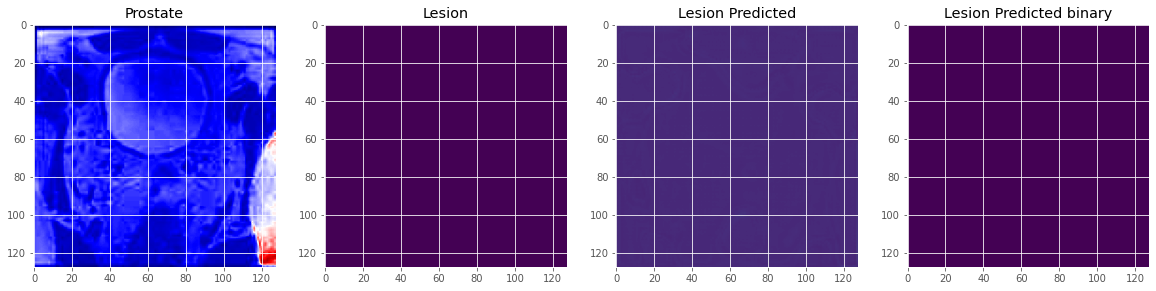

In [29]:
# Check if valid data looks all right
plot_sample(X_valid, y_valid, preds_val, preds_val_t, ix=19)

<ipython-input-23-111460d6459c>:11: UserWarning: No contour levels were found within the data range.
  ax[0].contour(y[ix].squeeze(), colors='k', levels=[0.5])
<ipython-input-23-111460d6459c>:19: UserWarning: No contour levels were found within the data range.
  ax[2].contour(y[ix].squeeze(), colors='k', levels=[0.5])
<ipython-input-23-111460d6459c>:24: UserWarning: No contour levels were found within the data range.
  ax[3].contour(y[ix].squeeze(), colors='k', levels=[0.5])


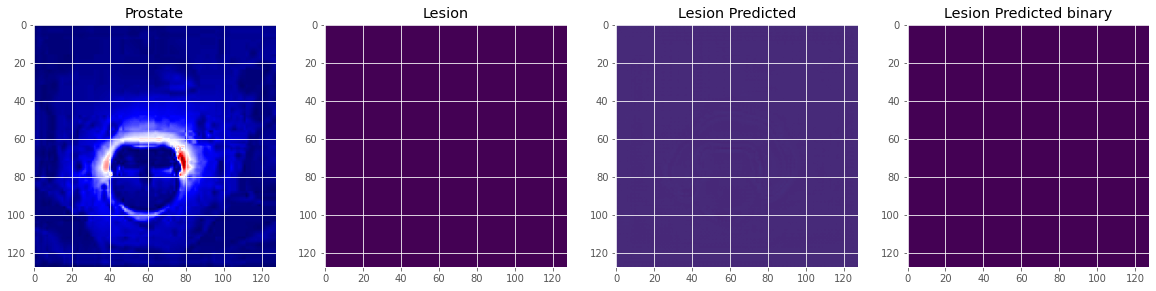

In [30]:
plot_sample(X_valid, y_valid, preds_val, preds_val_t)

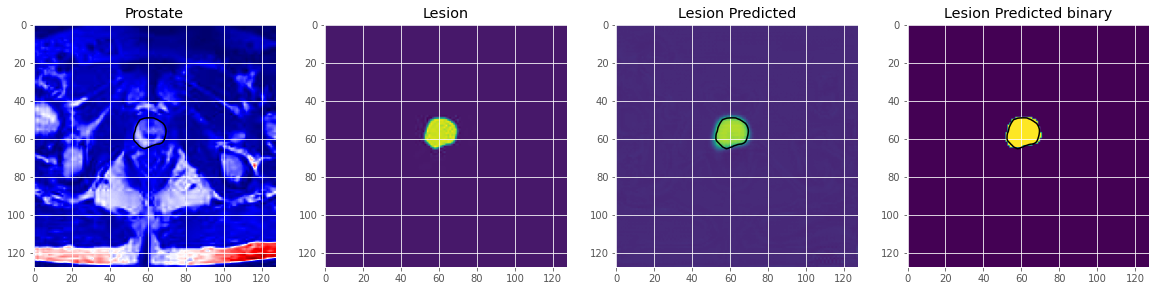

In [31]:
plot_sample(X_valid, y_valid, preds_val, preds_val_t)

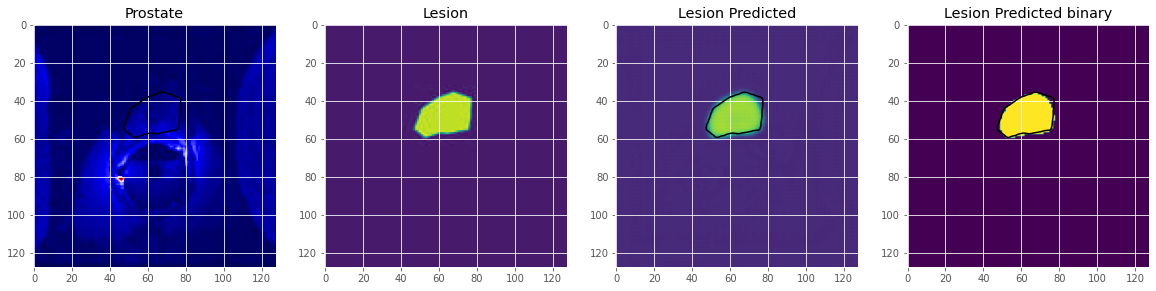

In [32]:
plot_sample(X_valid, y_valid, preds_val, preds_val_t)

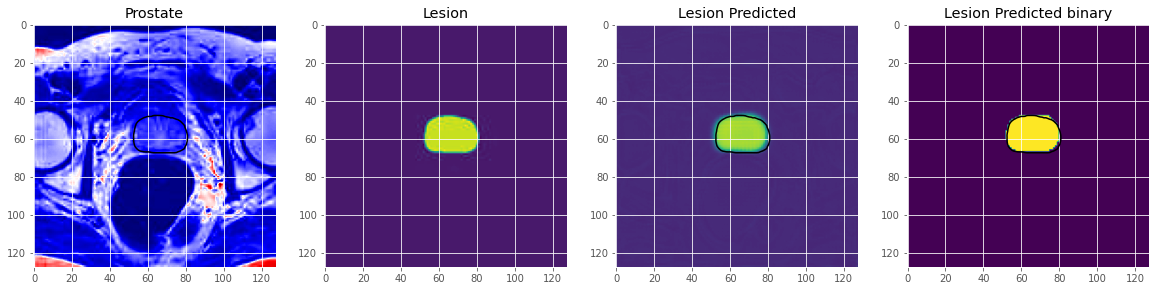

In [33]:
plot_sample(X_valid, y_valid, preds_val, preds_val_t)

<ipython-input-23-111460d6459c>:11: UserWarning: No contour levels were found within the data range.
  ax[0].contour(y[ix].squeeze(), colors='k', levels=[0.5])
<ipython-input-23-111460d6459c>:19: UserWarning: No contour levels were found within the data range.
  ax[2].contour(y[ix].squeeze(), colors='k', levels=[0.5])
<ipython-input-23-111460d6459c>:24: UserWarning: No contour levels were found within the data range.
  ax[3].contour(y[ix].squeeze(), colors='k', levels=[0.5])


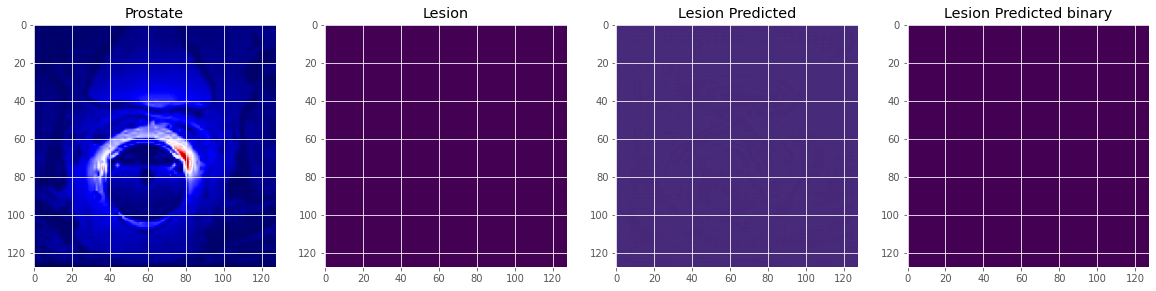

In [34]:
plot_sample(X_valid, y_valid, preds_val, preds_val_t)

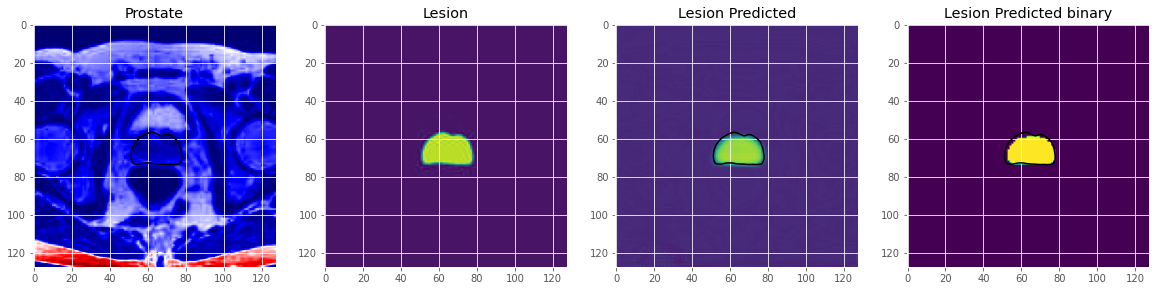

In [35]:
plot_sample(X_valid, y_valid, preds_val, preds_val_t)

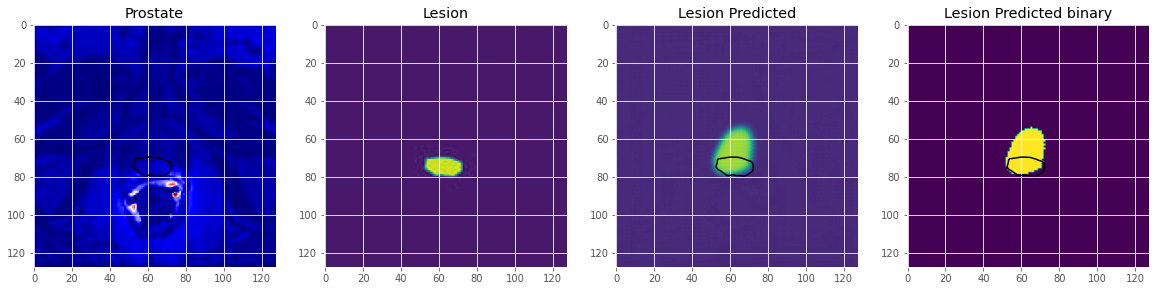

In [36]:
plot_sample(X_valid, y_valid, preds_val, preds_val_t)

<ipython-input-23-111460d6459c>:11: UserWarning: No contour levels were found within the data range.
  ax[0].contour(y[ix].squeeze(), colors='k', levels=[0.5])
<ipython-input-23-111460d6459c>:19: UserWarning: No contour levels were found within the data range.
  ax[2].contour(y[ix].squeeze(), colors='k', levels=[0.5])
<ipython-input-23-111460d6459c>:24: UserWarning: No contour levels were found within the data range.
  ax[3].contour(y[ix].squeeze(), colors='k', levels=[0.5])


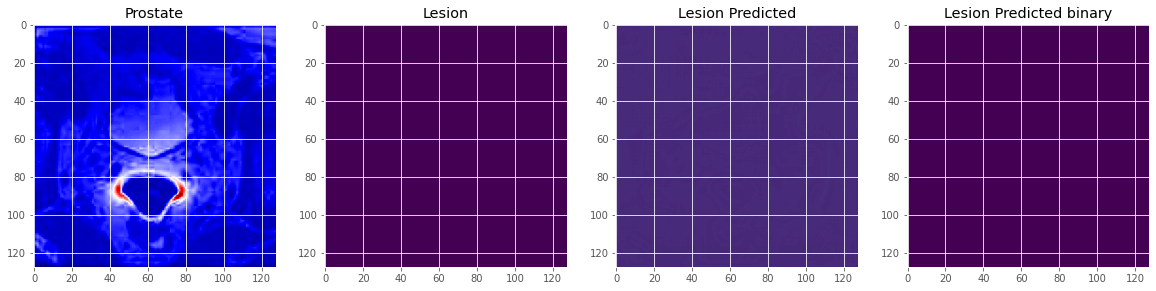

In [37]:
plot_sample(X_valid, y_valid, preds_val, preds_val_t)

<ipython-input-23-111460d6459c>:11: UserWarning: No contour levels were found within the data range.
  ax[0].contour(y[ix].squeeze(), colors='k', levels=[0.5])
<ipython-input-23-111460d6459c>:19: UserWarning: No contour levels were found within the data range.
  ax[2].contour(y[ix].squeeze(), colors='k', levels=[0.5])
<ipython-input-23-111460d6459c>:24: UserWarning: No contour levels were found within the data range.
  ax[3].contour(y[ix].squeeze(), colors='k', levels=[0.5])


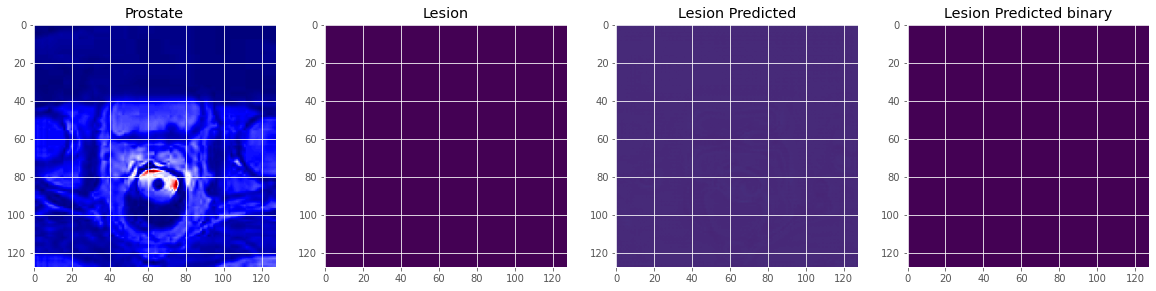

In [38]:
plot_sample(X_valid, y_valid, preds_val, preds_val_t)

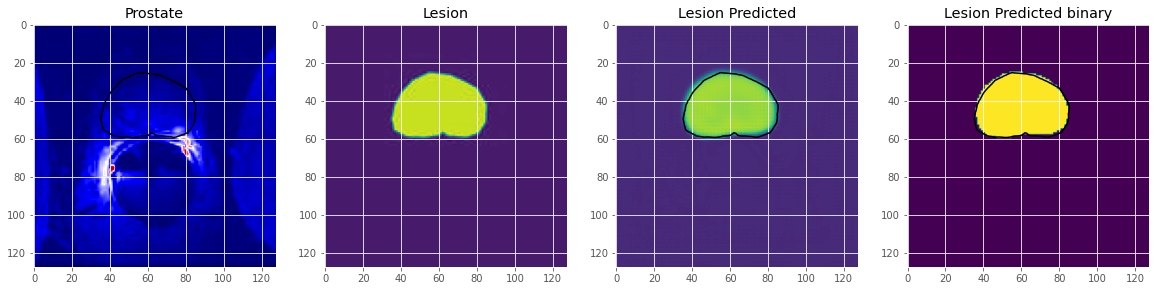

In [39]:
plot_sample(X_valid, y_valid, preds_val, preds_val_t)

<ipython-input-23-111460d6459c>:11: UserWarning: No contour levels were found within the data range.
  ax[0].contour(y[ix].squeeze(), colors='k', levels=[0.5])
<ipython-input-23-111460d6459c>:19: UserWarning: No contour levels were found within the data range.
  ax[2].contour(y[ix].squeeze(), colors='k', levels=[0.5])
<ipython-input-23-111460d6459c>:24: UserWarning: No contour levels were found within the data range.
  ax[3].contour(y[ix].squeeze(), colors='k', levels=[0.5])


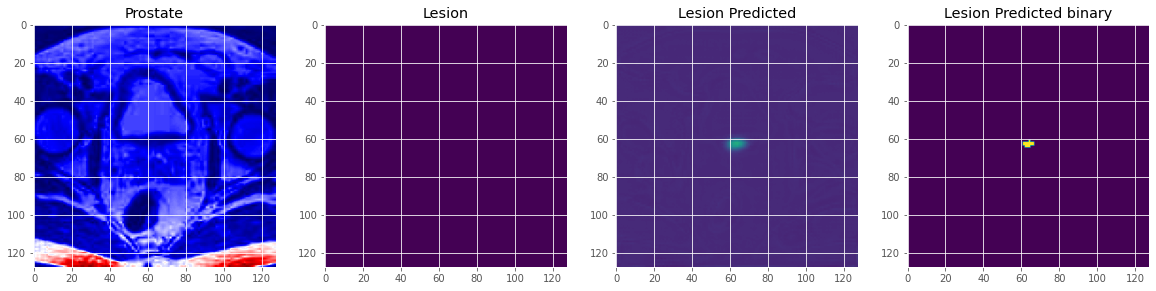

In [40]:
plot_sample(X_valid, y_valid, preds_val, preds_val_t)

<ipython-input-23-111460d6459c>:11: UserWarning: No contour levels were found within the data range.
  ax[0].contour(y[ix].squeeze(), colors='k', levels=[0.5])
<ipython-input-23-111460d6459c>:19: UserWarning: No contour levels were found within the data range.
  ax[2].contour(y[ix].squeeze(), colors='k', levels=[0.5])
<ipython-input-23-111460d6459c>:24: UserWarning: No contour levels were found within the data range.
  ax[3].contour(y[ix].squeeze(), colors='k', levels=[0.5])


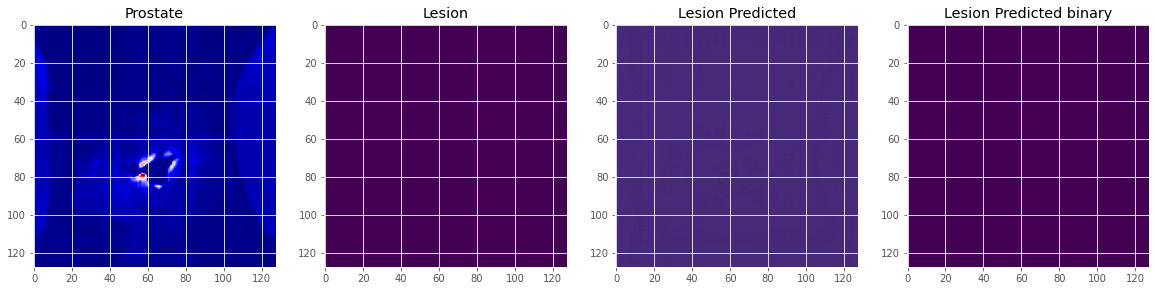

In [41]:
plot_sample(X_valid, y_valid, preds_val, preds_val_t)

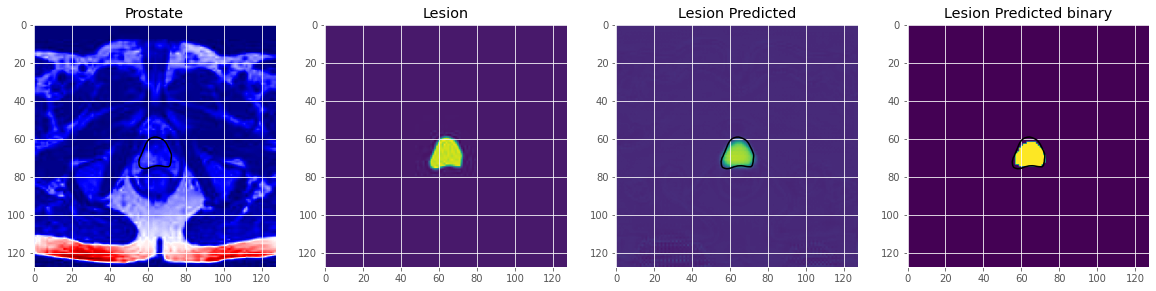

In [42]:
plot_sample(X_valid, y_valid, preds_val, preds_val_t)

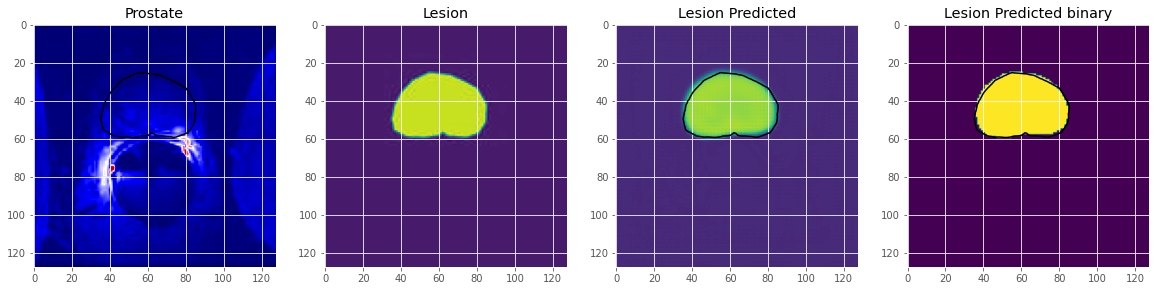

In [43]:
plot_sample(X_valid, y_valid, preds_val, preds_val_t)

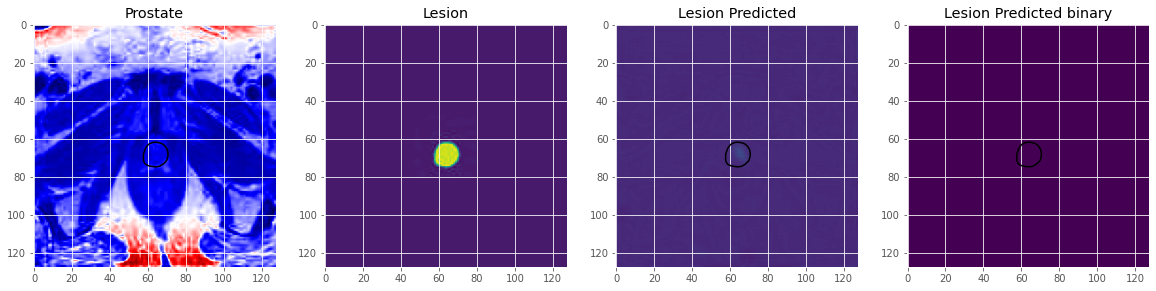

In [44]:
plot_sample(X_valid, y_valid, preds_val, preds_val_t)